#### Algorithm 1
##### Initial version

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
import math 
import matplotlib.pyplot as plt

In [3]:
sns.set_theme()

In [4]:
##reading old data
mat = scipy.io.loadmat('azip.mat')
A_train = mat['azip'] #matrix 265 x 1707, one column is one digit
mat = scipy.io.loadmat('dzip.mat')
D_train = mat['dzip'] #matrix 1 x 1707, info about A
k = np.unique(D_train).size

In [5]:
#reading unknown data
mat = scipy.io.loadmat('atest.mat')
A_test = mat['testzip'] 
mat = scipy.io.loadmat('dtest.mat')
D_test = mat['dtest'] 

In [10]:
def my_HOSVD(T):

    U1, _, _ = np.linalg.svd(tl.unfold(T, 0), full_matrices=False) 
    U2, _, _ = np.linalg.svd(tl.unfold(T, 1), full_matrices=False) 
    U3, _, _ = np.linalg.svd(tl.unfold(T, 2), full_matrices=False)

    S = tl.tenalg.multi_mode_dot(T, [np.transpose(U1),np.transpose(U2),np.transpose(U3)], modes = [0,1,2], transpose=False)
    
    return(S, U1, U2, U3)

In [15]:
def alg1_train(A_train, D_train,  k):
    #prima matricu podataka A gdje je jedan stupac jedan podataka, matricu D koja opisuje A i broj klastera
    #vraća listu duljine k tenzora čiji su frontalni slicevi bazne matrice k-tog klastera
    
    #T = np.zeros((int(math.sqrt(A_train.shape[0])),int(math.sqrt(A_train.shape[0])), A_train.shape[1]))
    tensor = [None] * k
    
    for i in range(k):

        T = tl.vec_to_tensor(A_train[:, np.where(D_train == i)[1]], (16,16,A_train[:, np.where(D_train == i)[1]].shape[1])) #tenzor i-te znamenke 
        S, U1, U2, _ = my_HOSVD(T)
    
        tensor[i] = np.zeros((int(math.sqrt(A_train.shape[0])),int(math.sqrt(A_train.shape[0])), S.shape[2]))

        for j in range(S.shape[2]):
            pom = np.matmul(U1, S[:,:,j])
            tensor[i][:, :, j] = np.matmul(pom, np.transpose(U2)) / np.linalg.norm(np.matmul(pom, np.transpose(U2)))
            
    return(tensor)

In [17]:
output = alg1_train(A_train,D_train, k)
correct = 0

for i in range(A_test.shape[1]): 
    D = np.reshape((A_test[:, i] / np.linalg.norm(A_test[:, i])), (16,16))
    min_R = 1
    min_zn = 0 
    
    for j in range(len(output)):
        R = 1
        for z in range(output[j].shape[2]):
            R -= np.sum( np.trace(np.matmul(np.transpose(D), output[j][:,:,z])) ** 2)
            
        if( R < min_R): 
            min_R = R
            min_zn = j
            
    if( D_test[0][i] == min_zn):
        correct += 1
    
correct / D_test.shape[1]

0.17638266068759342

#### Algoritam 2

In [126]:
def construct_tensort(A): #A is matrix, one column is one data
    
    T = np.zeros((int(math.sqrt(A.shape[0])),int(math.sqrt(A.shape[0])), A.shape[1]))
    

    for i in range((A.shape[1])):
        T[:,:,i] = np.reshape( A[:, i], (int(math.sqrt(A.shape[0])),int(math.sqrt(A.shape[0]))) )
        
    return(T)

In [120]:
def sort_tensor(T, D): #T is tensor, D is correct output for each frontal slice
    
    T_solution = np.empty((16,16,1707))
    
    for i in range(k):
        if(i == 0):
            T_solution[:,:,0: len(np.where(D == i)[1])] = T[:,:,np.where(D == i)[1]]
        else:
            T_solution[:,:,len(np.where(D == (i-1))[1]) : len(np.where(D == (i-1))[1]) + len(np.where(D == i)[1])] = T[:,:,np.where(D == i)[1]]
    
    return(T_solution)

#ovo provjeriti jel još okej

In [27]:
def my_HOSVD(T):

    U1, _, _ = np.linalg.svd(tl.unfold(T, 1), full_matrices=False) 
    U2, _, _ = np.linalg.svd(tl.unfold(T, 2), full_matrices=False) 
    U3, _, _ = np.linalg.svd(tl.unfold(T, 0), full_matrices=False)

    S = tl.tenalg.multi_mode_dot(T, [np.transpose(U1),np.transpose(U2),np.transpose(U3)], modes = [0,1,2], transpose=False)
    
    return(S, U1, U2, U3)

In [111]:
def plot_norm(T):
    
    norm_1 = np.zeros(T.shape[0]) 
    for i in range(T.shape[0]):
        norm_1[i] = np.linalg.norm(T[i,:,:]) ** 2 #optimizirati naknadno: suma dij!

    norm_2 = np.zeros(T.shape[1])   
    for i in range(T.shape[1]):
        norm_2[i] = np.linalg.norm(T[:,i,:]) ** 2

    norm_3 = np.zeros(T.shape[2])   
    for i in range(T.shape[2]):
        norm_3[i] = np.linalg.norm(T[:,:,i]) ** 2

    df_ = pd.DataFrame(data = {'Mode 1':norm_1, 'Mode 2':norm_2}) #opt isto
    df__ = pd.DataFrame(data = {'Mode 3':norm_3})
    df = pd.concat([df_,df__], ignore_index=True, axis=1)

    sns.lineplot(data = df)
    

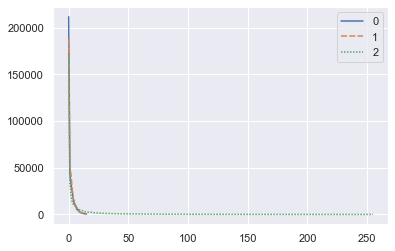

In [130]:
##reading data
mat = scipy.io.loadmat('azip.mat')
A = mat['azip'] #matrix 265 x 1707, one column is one digit
mat = scipy.io.loadmat('dzip.mat')
D = mat['dzip'] #matrix 1 x 1707, info about A
k = np.unique(D).size

#construct tensor from A
T = construct_tensort(A)

#sort tensor
T = sort_tensor(T, D)

#make HOSVD
F = my_HOSVD(T)

#plot norms
plot_norm(F)


25.2.2022,

In [2]:
mat = scipy.io.loadmat('azip.mat')
A_train = mat['azip'] #matrix 265 x 1707, one column is one digit
mat = scipy.io.loadmat('dzip.mat')
D_train = mat['dzip'] #matrix 1 x 1707, info about A
k = np.unique(D_train).size

In [50]:
def multiplication(T, M, mode): #funkcija za množenje tenzora i matrice u modu m
    descriptor = list(T.shape)
    descriptor[mode] = M.shape[0]
    return (tl.fold( M @ tl.unfold(T, mode), mode, descriptor))   

In [47]:
def HOSVD2(T, p, q):
    U1, _, _ = np.linalg.svd(tl.unfold(T, 1), full_matrices=False)
    U2, _, _ = np.linalg.svd(tl.unfold(T, 2), full_matrices=False)
    F_ = multiplication(T, np.transpose(U1[:, 0:p]), 1)
    F = multiplication(F_, np.transpose(U2[:, 0:q]), 2)
    return F, U1[:, 0:p]

In [62]:
def alg2_train(F, k):
    B = np.zeros((F.shape[0], k, k ))
    for mi in range(F.shape[2]):
        U, _, _ = np.linalg.svd(F[:, :, i], full_matrices=False)
        B[:, :, mi] = U[:, 0:k]
    return(B)

In [66]:
def alg2_test(A_test, B, U_p):
    
    digits = []
    
    for j in range(A_test.shape[1]):
        
        d = A[:, j]
        d = U_p @ d 
        
        r = []
        
        for k in range(B.shape[2]):
            r.append(np.linalg.norm(d - B[:,:,k] @ (np.transpose(B[:,:k]) @ d)))
        
        digits.append(np.argmin(r))

    return digits        
    

In [67]:
#konstrukcija tenzora
T = np.empty((256,400,10))

for i in range(k): 
    T[:, 0:A_train[:, np.where(D_train == 2)[1]].shape[1], i] = A_train[:, np.where(D_train == 2)[1]]